#[1] Mount Google Drive

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')

Mounted at /content/drive


#[2] Setting up Environment and Install Requirements

In [ ]:
%%capture
!pip install transformers
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
# Import External Libs
import pandas as pd
import numpy as np
import datetime as dt
import re
import random
from selenium import webdriver

import torch
from transformers import AdamW, BartForConditionalGeneration

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank


import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Content/tools/articles/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
#font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

In [ ]:
# Define Path
path_records = '/content/drive/MyDrive/Github/Content/tools/articles/records'

In [ ]:
# Set Working Directory
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

# Load Libraries Local
%load_ext autoreload
%reload_ext autoreload

from sources.ChinaFilm.Record_Registration import Registration
from sources.ChinaFilm.Record_Release import Release
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Instantiate Classes
driver = webdriver.Chrome('chromedriver',options=chrome_options)

dy_reg = Registration(driver)
dy_rel = Release()

# [3] Load Release and Registration Records

In [ ]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
# Import Releases
df_releases = pd.read_json(dy_rel.path_records + '//' + 'contents_of_releases.json')
df_releases_doc = df_releases[df_releases['电影类别'].str.contains('纪录')]

# Import Reg
df_reg = pd.read_json(dy_reg.path_records + '//' + 'contents_of_registrations.json')
df_reg = dy_reg.Refined_Records(df_reg)
df_reg['匹配片名'] = df_reg['片名']

In [ ]:
dt_curr_release = df_releases_doc['公示日期'].astype('datetime64').iloc[0]
str_date_curr_release = '{}年{}月{}日'.format(str(dt_curr_release.year),
                                        str(dt_curr_release.month),
                                        str(dt_curr_release.day)
                                        )
str_date_curr_release
issue_name = str_date_curr_release

In [ ]:
print(df_releases_doc.columns)
print(df_releases_doc.shape[0])

Index(['序号', '电影类别', '编码', '公映证号', '片名', '第一出品单位', '公示批次链接', '公示名称', '公示日期'], dtype='object')
58


# [4] Identify Documentaries in Theaters

In [ ]:
# Search for docs not in release publications but already in theater
df_releases[df_releases['片名'].str.contains('一个村庄的文学')]
df_reg[df_reg['片名'].str.contains('1950')]

In [ ]:
# identify docs in theater from registration
idx_onscreen = [3313, 6423, 7011]
df_onscreen = df_reg[df_reg.index.isin(idx_onscreen)]
df_onscreen = df_onscreen.append(pd.Series(), ignore_index = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Manually input records for docs not in reg but in theater, i.e. imported films
df_onscreen.index = idx_onscreen + ['i1']

df_onscreen.loc['i1', '片名'] = '好好拍电影'
df_onscreen.loc['i1', '编剧'] = '文念中'
df_onscreen.loc['i1', '备案地'] = '香港'
df_onscreen.loc['i1', '梗概'] = '许鞍华生于辽宁，长于澳门，受教于香港，在中西文化的夹缝中成长与求索。取得香港大学英文及比较文学专业硕士学位后，她远赴伦敦进修。在那里，她找到了电影，从此再没停下脚步。此后，许鞍华师承胡金铨，处女作开辟香港电影新浪潮；于商业与艺术、 类型与文艺之间游走，不断探索自己和这座城市的漂泊状态；六夺金像 三斩金马，仍要为投资犯难发愁；从早年获奖无数到跌入谷底，从不放弃忠于创作的机会。许鞍华对电影和香港始终一片赤诚， 电影伴她活出了人生的圆满'

df_onscreen['主题'] = ['人物聚焦']*4
df_onscreen['出品方属性'] = ['民营']*4

df_onscreen['img_poster'] = ['1950他们正年轻.png', '龙虎武师.jpg',
                             '一直游到海水变蓝.png', '好好拍电影.png']


In [ ]:
df_releases_doc['片名'].to_numpy()

array(['我是城管', '岁月在这儿', '我爱你，中国', '无臂七子', '光语者', '一直游到海水变蓝', '金沙江畔',
       '蓝色防线', '穿越丝路的花雨', '城市梦', '往事如昨', '大黄一家人', '守护你', '五埠岭过大年', '棒！少年',
       '保家卫国——抗美援朝光影纪实', '我们和《金刚川》', '2019阅兵盛典', '十字街口', '好功夫1少林我来了',
       '风流寡妇', 'Hello 北京', '大河唱', '画时代', '孝义传家风 别样中国年', '共同命运', '时光机',
       '走过四季', '诗与真', '脊柱医生', '大理的声音', '民间艺术——莲花落', '零零后', '这一年',
       '大戏记忆——程婴救孤', '大戏记忆——花木兰', '大戏记忆——穆桂英挂帅', '爱我长城', '豆浆油条', '天工苏作',
       '归来是少年', '鹭世界', '极地', '我是车手', '藏羚王之宝贝日记——极地追踪', '变化中的中国·生活因你而火热',
       '五禽戏', '书匠', '六人——泰坦尼克上的中国幸存者', '纽伦堡的名歌手（上）', '纽伦堡的名歌手（下）',
       '此时此刻·2019大阅兵', '巅峰体验', '掬水月在手', '澳门记忆', '青春 中国', '日暮·归乡', '骑车去西藏'],
      dtype=object)

#[5] Interactively Find matches

In [ ]:
# Check for unmatched records and perform mannual matches
df_matched = df_reg[df_reg['匹配片名'].isin(df_releases_doc['片名'].to_numpy())]
dftmp_unmatched = df_releases_doc.loc[~df_releases_doc['片名'].isin(df_matched['片名'].to_numpy())]
dftmp_unmatched['片名']

333           一直游到海水变蓝
334               金沙江畔
335               蓝色防线
343     保家卫国——抗美援朝光影纪实
344           我们和《金刚川》
675           2019阅兵盛典
676               十字街口
677          好功夫1少林我来了
742           Hello 北京
743                大河唱
747                时光机
748               走过四季
754                这一年
755         大戏记忆——程婴救孤
756          大戏记忆——花木兰
757        大戏记忆——穆桂英挂帅
760               天工苏作
765     藏羚王之宝贝日记——极地追踪
766     变化中的中国·生活因你而火热
768                 书匠
769    六人——泰坦尼克上的中国幸存者
773               巅峰体验
777              日暮·归乡
Name: 片名, dtype: object

In [ ]:
print(len(dftmp_unmatched['片名'].to_numpy()))
print(dftmp_unmatched['片名'].to_numpy())
print('\n')
print(dftmp_unmatched['第一出品单位'].to_numpy())

23
['一直游到海水变蓝' '金沙江畔' '蓝色防线' '保家卫国——抗美援朝光影纪实' '我们和《金刚川》' '2019阅兵盛典' '十字街口'
 '好功夫1少林我来了' 'Hello 北京' '大河唱' '时光机' '走过四季' '这一年' '大戏记忆——程婴救孤' '大戏记忆——花木兰'
 '大戏记忆——穆桂英挂帅' '天工苏作' '藏羚王之宝贝日记——极地追踪' '变化中的中国·生活因你而火热' '书匠'
 '六人——泰坦尼克上的中国幸存者' '巅峰体验' '日暮·归乡']


['山西西河星汇文化传播有限公司' '国家大剧院' '河南电影电视制作集团有限公司' '中国电影股份有限公司' '中国电影股份有限公司'
 '中国人民解放军八一电影制片厂' '山西广电音像出版有限责任公司' '重庆力豪影视文化传媒有限公司' '优尼影视文化传媒（北京）有限公司'
 '北京天空之城影视有限公司' '上海飞屋影业有限公司' '天山电影制片厂' '山西广电音像出版有限责任公司' '中国农业电影电视中心'
 '中国农业电影电视中心' '中国农业电影电视中心' '苏州市广播电视总台' '深圳市天宇星影视文化有限公司' None
 '陕西培植影视文化传播有限公司' '上海罗家文化艺术交流有限公司' '极乐影视传媒（上海）有限公司' '浙江横店影业有限公司']


In [ ]:
df_reg.loc[df_reg['备案单位'].fillna('').str.contains(
    '中国农业电影电视中心'), ['片名', '备案单位', '编剧', '梗概', '公示日期', '电影类别']]

In [ ]:
df_reg.loc[df_reg['梗概'].fillna('').str.contains('日暮归乡'), 
           ['片名', '备案单位', '编剧', '梗概', '电影类别']]

,片名,备案单位,编剧,梗概,电影类别


In [ ]:
df_reg.loc[df_reg['片名'].fillna('').str.contains('花木兰'), 
           ['片名', '备案单位', '编剧', '梗概', '电影类别']]

In [ ]:
df_reg.loc[(df_reg['电影类别'].fillna('').str.contains('纪录'))
            #&
           #(df_reg['梗概'].fillna('').str.contains('四季'))
           ,
           ['片名', '备案单位', '编剧', '梗概', '电影类别']]

In [ ]:
# 'Release Name': 'RegName'
mmatch = {
          '一直游到海水变蓝':'一个村庄的文学',
          '金沙江畔': '金沙江畔（歌剧）',
          '蓝色防线':'中国蓝盔在行动之步兵出击',
          '保家卫国——抗美援朝光影纪实': '保家卫国——抗美援朝纪实',
          '我们和《金刚川》':'我们和金刚川',
          '2019阅兵盛典':'国庆70周年阅兵',
          '十字街口': '泽火革',
          '好功夫1少林我来了':'少林我来了',
          'Hello 北京': '哈喽！北京！',
          '大河唱': '黄河今流',
          '时光机':'马良的时光机',
          '走过四季':'塔玛牧道',
          '这一年':'赵家洼纪事',
          '大戏记忆——程婴救孤':'大戏记忆？程婴救孤',
          '大戏记忆——花木兰':'大戏记忆●花木兰',
          '大戏记忆——穆桂英挂帅':'大戏记忆 ●穆桂英挂帅',
          '天工苏作':'天工',
          '藏羚王之宝贝日记——极地追踪':'藏羚王之宝贝日记—极地追踪',
          '变化中的中国·生活因你而火热':'生活万岁',
          '书匠':'老书',
          '六人——泰坦尼克上的中国幸存者':'六人：泰坦尼克号上的中国幸存者',
          '巅峰体验':'一群人的朝圣',
          '日暮·归乡':'日暮？归乡',

          }

In [ ]:
# Merge Manually Identified name
df_releases_doc['匹配片名'] = df_releases_doc['片名'].apply(lambda x: mmatch[x] if x in mmatch else x)
df_matched = df_reg[df_reg['匹配片名'].isin(df_releases_doc['匹配片名'].to_numpy())]
df_matched = df_matched[['备案立项号', '匹配片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期']].copy()
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df_c = df_releases_doc.merge(df_matched, on='匹配片名', how='left')
df_c['备案公示日期'] = df_c['备案公示日期'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
df_c['备案至获得公映许可'] =  pd.to_datetime(df_c['公示日期']) - pd.to_datetime(df_c['备案公示日期'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_c.columns

Index(['序号', '电影类别', '编码', '公映证号', '片名', '第一出品单位', '公示批次链接', '公示名称', '公示日期',
       '匹配片名', '备案立项号', '备案单位', '编剧', '备案结果', '备案地', '梗概', '备案公示日期',
       '备案至获得公映许可'],
      dtype='object')

In [ ]:
df_c['备案至获得公映许可']

0    1194 days
1     460 days
2     915 days
3    1321 days
4    1085 days
5     614 days
6     881 days
7    1504 days
8     550 days
9     587 days
10    460 days
11   1050 days
12    340 days
13    571 days
14    529 days
15    172 days
16     83 days
17    279 days
18    433 days
19    644 days
20    904 days
21    998 days
22   1362 days
23    904 days
24    615 days
25   1246 days
26    615 days
27   1388 days
28    433 days
29    615 days
30    937 days
31    700 days
32   1355 days
33    637 days
34    362 days
35    362 days
36    362 days
37    869 days
38    644 days
39    946 days
40    433 days
41    978 days
42    937 days
43   1301 days
44    336 days
45    998 days
46    490 days
47   1566 days
48    734 days
49    615 days
50    615 days
51    279 days
52    505 days
53    734 days
54    615 days
55    362 days
56    799 days
57    978 days
Name: 备案至获得公映许可, dtype: timedelta64[ns]

In [ ]:
df_c

In [ ]:
# identify idx to drop,  records with same name but not of same project
idx_to_drop = []
df = df_c.copy()
if idx_to_drop:
  df.drop(idx_to_drop, inplace=True)

In [ ]:
df.info()

In [ ]:
df

# [6] Run Models for prediction
 - genre  - time  - title

## Assign topic, accumulate for ML later

In [ ]:
df['梗概'].to_numpy()

In [ ]:
ls_topics = ['人物聚焦', '历史变迁', '人物聚焦', '人物聚焦', '考古',
 '人物聚焦', '戏曲', '战争与革命', '人文艺术', '人物聚焦',
'人物聚焦', '人物聚焦','人物聚焦','乡村','人文体育',
'战争与革命', '制作记录', '演出与活动', '人物聚焦', '制作记录',
'人物聚焦', '人物聚焦','人物聚焦','人文风光','人物聚焦',
'人物聚焦', '人物聚焦', '人物聚焦', '人物聚焦', '人物聚焦',
'人文风光', '人物聚焦','人物聚焦','乡村','戏曲',
'戏曲', '戏曲', '人物聚焦', '人物聚焦', '人文艺术',
'人文风光', '自然与动物','人物聚焦','人文游记','自然与动物',
'人物聚焦', '人物聚焦', '人物聚焦', '人物聚焦', '人物聚焦',
'人物聚焦', '演出与活动', '人文游记', '人物聚焦', '历史变迁',
'历史变迁', '人物聚焦', '人文游记', 
]

df['主题'] = ls_topics
#HTML(df[['梗概']][50:60].to_html())
# '演出与活动'， '制作记录'， '自然与动物'，'历史变迁'

## Identify gvt and private

In [ ]:
ls_co_gvt = ['中国数字文化集团有限公司',
             '中国农业电影电视中心',
             '中央新闻纪录电影制片厂（集团）',
             '深圳广播电影电视集团',
             '深圳广电影视股份有限公司',
             '山东新农村数字电影院线有限公司',
             '青海广电影视传媒有限公司',
             '珠江电影集团有限公司',
             '国家大剧院',
             '河南电影电视制作集团有限公司',
             '中国电影股份有限公司',
             '八一电影制片厂',
             '山西广电音像出版有限责任公司',
             '北京师范大学',
             '苏州市广播电视总台',
             '苏州市非物质文化遗产保护管理办公室',
             '苏州市文化研究中心',
             '中央广播电视总台',
             ]
#df['备案单位'].unique()

In [ ]:
df['出品方属性'] = None
df.loc[df['备案单位'].str.contains('|'.join(ls_co_gvt)), '出品方属性'] = '官方'
df.loc[~df['备案单位'].str.contains('|'.join(ls_co_gvt)), '出品方属性'] = '民营'

## Predict Genre

In [ ]:
# Define Labels
label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k

In [ ]:
%%capture
# Genre Classifier
N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['类型'] = test_predictions
df['类型'] = df['类型'].apply(lambda x: id2label_genre[x])

In [ ]:
batch_size = 4
i = 0
ls = df_onscreen['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_onscreen.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_onscreen['类型'] = test_predictions
df_onscreen['类型'] = df_onscreen['类型'].apply(lambda x: id2label_genre[x])

## Predict Time

In [ ]:
# Define Labels
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k

In [ ]:
%%capture
# Time Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['年代'] = test_predictions
df['年代'] = df['年代'].apply(lambda x: id2label_time[x])

In [ ]:
batch_size = 4
i = 0
ls = df_onscreen['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_onscreen.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_onscreen['年代'] = test_predictions
df_onscreen['年代'] = df_onscreen['年代'].apply(lambda x: id2label_time[x])

## Predict Title

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

  
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint,
                                            gradient_checkpointing=True, 
                                            use_cache=False)
model.to(device)
model.eval()

In [ ]:
batch_size = 8
i = 0
ls = df['梗概'].tolist()
L = df['梗概'].shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [ ]:
batch_size = 4
i = 0
ls = df_onscreen['梗概'].tolist()
L = df_onscreen['梗概'].shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [ ]:
df['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df['预测片名'] = df['预测片名'].apply(remove_specials)

In [ ]:
df_onscreen['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df_onscreen['预测片名'] = df_onscreen['预测片名'].apply(remove_specials)

In [ ]:
df_onscreen

,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,电影类别,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数,匹配片名,主题,出品方属性,年代,预测片名
3313,影纪备字[2020]第293号,1950他们正年轻,五洲传播出版社、永顺（北京）电影制作有限公司,宋学志,同意拍摄,直备,2020抗美援朝70周年之际，聚焦70年前参战的普通年轻人，走访志愿军老兵，听他们口述70年...,2020-11-03,国家电影局关于2020年5月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,纪录片,2020,"(2020, 5, 整月, 5, 整月)",都市,2020,293,"DatetimeIndex(['2020-05-01', '2020-05-02', '20...",31,1950他们正年轻,人物聚焦,民营,当代,青春与梦想
6423,影纪备字[2019]第092号,龙虎武师,北京集智映像影视文化有限公司,魏海军,同意拍摄,北京市,风靡世界的香港动作电影，背后是几代武行的拼搏努力。本片通过访问拍摄近百位武行前辈以及入行新人...,2019-08-15,国家电影局关于2019年06月（中旬）全国电影剧本（梗概）备案、立项公示的通知-电影备案立项...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,纪录片,2019,"(2019, 06, 中旬, 06, 中旬)",其它,2019,92,"DatetimeIndex(['2019-06-11', '2019-06-12', '20...",10,龙虎武师,人物聚焦,民营,现代,武林英雄
7011,影纪备字[2019]第123号,一个村庄的文学,山西西河星汇文化传播有限公司,贾樟柯,同意拍摄,山西省,影片从数十位作家参与、于乡村举办的吕梁文学季开始，追忆马烽，讲述贾平凹、莫言、余华等作家所经...,2019-05-22,国家电影局关于2019年04月（中旬）全国电影剧本（梗概）备案、立项公示的通知-电影备案立项...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,纪录片,2019,"(2019, 04, 中旬, 04, 中旬)",其它,2019,123,"DatetimeIndex(['2019-04-11', '2019-04-12', '20...",10,一个村庄的文学,人物聚焦,民营,当代,我们的村庄
i1,<NA>,好好拍电影,<NA>,文念中,<NA>,香港,许鞍华生于辽宁，长于澳门，受教于香港，在中西文化的夹缝中成长与求索。取得香港大学英文及比较文...,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,其它,<NA>,<NA>,NaN,<NA>,<NA>,人物聚焦,民营,当代,许鞍华


## Extract top keywords

In [ ]:
df['kw'] = df['梗概'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.837 seconds.
Prefix dict has been built successfully.


In [ ]:
df_onscreen['kw'] = df_onscreen['梗概'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.968 seconds.
Prefix dict has been built successfully.


## Identify Main Characters

In [ ]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [ ]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

In [ ]:
df['主要角色'] = df['梗概'].apply(find_PER)

In [ ]:
df_onscreen['主要角色'] = df_onscreen['梗概'].apply(find_PER)

In [ ]:
df_onscreen

## View Table


In [ ]:
df[['备案单位','第一出品单位']]

In [ ]:
# Formulat view table
tmp = df[['备案单位','第一出品单位']].fillna('').apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1
df_view = df[['片名', '匹配片名','梗概', '备案至获得公映许可', '备案结果', 
              '第一出品单位', '备案单位', '公司变更', '编剧', '主题', 'genre', 'time', 'kw']].copy()
df_view.loc[df_view['片名'] == df_view['匹配片名'], '匹配片名'] = ''
df_view.rename(columns={'匹配片名':'备案名'}, inplace=True)
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.loc[df_view['备案结果'].str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)
df_view['备案至获得公映许可'] = round(
    (df_view['备案至获得公映许可'].dt.days + 60) / 365, 1)
df_view.sort_values(by='备案至获得公映许可', ascending=False, inplace=True)
df_view['备案至获得公映许可'] = df_view['备案至获得公映许可'].apply(
    lambda x: '> ' + str(x) + ' 年')
df_view.drop('公司变更', axis=1, inplace=True)
df_view

,片名,备案名,梗概,备案至获得公映许可,是否修改,第一出品单位,原备案单位,编剧,主题,genre,time,kw
47,书匠,老书,影片记录了一位酷爱陕北民间艺术的老者，多年来一直在陕北这块土地上为保护陕北民间艺术四处奔走，...,> 4.5 年,,陕西培植影视文化传播有限公司,,曹建标,人物聚焦,其它,当代,"[陕北, 保护, 民间艺术, 酷爱, 物质, 文化遗产, 土地, 上为, 进行, 记录]"
7,蓝色防线,中国蓝盔在行动之步兵出击,本片讲述中国军人在危机来临的那一刻，坚守在任务一线，用鲜血和生命保护着南苏丹难民和联合国营地...,> 4.3 年,,河南电影电视制作集团有限公司,,尚昌仪,战争与革命,军旅,当代,"[苏丹, 保护, 军人, 中国, 来临, 危机, 讲述, 鲜血, 难民, 生命]"
27,走过四季,塔玛牧道,本纪录片从一个牧民的一家人，从部落到一个民族，记录一个时代和另一个时代的交替，塔玛牧道验证哈...,> 4.0 年,,天山电影制片厂,,哈依夏·塔巴热克、高黄刚,人物聚焦,其它,现代,"[时代, 牧民, 信念, 不屈, 民族, 草原, 生命, 活化石, 成为, 历史]"
32,零零后,,这是关于两个中国00后孩子的成长故事。这也是关于整代人的故事。 我们长达十年用镜头观察00后...,> 3.9 年,,北京同道真实文化传媒有限公司,北京师范大学,张同道,人物聚焦,都市,当代,"[中国, 社会, 成长, 故事, 孩子, 探讨, 学校, 观察, 家庭, 影响]"
22,大河唱,黄河今流,千百年来黄河沿岸的土地与生活方式一直在变迁，歌声也随之变化。影片将通过苏阳和影响他的四个黄河...,> 3.9 年,,北京天空之城影视有限公司,,包晓更,人物聚焦,其它,现代,"[黄河, 土地, 关注, 黄河流域, 变迁, 故事, 风生水, 生活, 艺人, 方式]"
3,无臂七子,,七位无臂艺术家，有着相似的生活悲剧，但他们都在逆境中不甘示弱，迸发出昂扬向上的勇气和力量。不...,> 3.8 年,,杭州何乐不为文化传媒有限公司,,金行征,人物聚焦,都市,当代,"[价值, 迸发出, 勇气, 相似, 有着, 证明, 艺术, 收获, 成就, 昂扬]"
43,我是车手,,这将是中国最艰难的汽车越野拉力赛，车手们将要在10多天的时间里极速穿越8000多公里。他们远...,> 3.7 年,,北京江山如画文化传媒有限公司,,袁鸿冰,人文游记,都市,当代,"[汽车, 荒野, 公路, 赛车, 赛车手, 冠军, 穿越, 挑战, 时间, 不惜]"
25,共同命运,,这部影片将选取在丝路沿线有代表性的区域内背景、身份、年龄各不相同的几个普通人，用镜头记录下他...,> 3.6 年,,北京丝路天下文化传播有限公司,,曲江涛,人物聚焦,其它,当代,"[丝路, 背景, 梦想, 命运, 记录, 普通人, 年龄, 生活, 身份, 区域]"
0,我是城管,,影片纪录了兰州市七里河区城管在创建文明城市下的一次集体大整治，纪录了城管与摊贩、拆迁户的博弈...,> 3.4 年,,兰州金城筏客影业有限公司,甘肃天宫科普文化传媒股份有限公司,杨洋,人物聚焦,都市,当代,"[城管, 摊贩, 纪录, 七里河区, 理解, 兰州市, 博弈, 拆迁户, 文明城市, 创建]"
4,光语者,,影片讲述了中国科考队员刘扬独自驻守中国北极科考站——黄河站，在长达120天的极夜中监测极光的...,> 3.1 年,,北京极光映像传媒有限公司,,卢武、吴建波、李穆穆,考古,其它,当代,"[中国, 队员, 影片, 极光, 科研, 故事, 黄河, 长达, 精神, 阐释]"


# [7] Generate WordCloud

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

def generate_word_image(ls_words, img_name):
  path_genre_icon = path_img + '/genre_icon/{}'.format(img_name)
  path_mask_image = path_img + '/genre_icon/mask_{}'.format(img_name)
  path_color_image = path_img + '/genre_icon/{}'.format(img_name)

  #wordcloud.color_from_image(coloring)
  mask = np.array(Image.open(path_mask_image)) # 定义词频背景
  coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
  #image_colors = wordcloud.ImageColorGenerator(mask) # 从背景图建立颜色方案
  #image_colors = wordcloud.ImageColorGenerator(coloring, default_color=(79, 46, 47))
  image_colors = wordcloud.ImageColorGenerator(coloring)
  #wc.recolor(color_func=image_colors,  random_state=3)

  #image_colors = wordcloud.ImageColorGenerator(mask) # 从背景图建立颜色方案

  wc = wordcloud.WordCloud(
      font_path=path_font,
      width = 300,
      height = 100,
      scale = 1,
      mask=mask, # set back ground mask image
      max_words=224,
      max_font_size=188,
      min_font_size=2,
      #mode="RGBA",
      mode="RGB",
      background_color='white',
      #background_color=None, 
      #background_color="rgba(255, 255, 255, 0)", 
      #contour_width=3, 
      #contour_color='steelblue',
      repeat=True,
      color_func=image_colors,
  )

  wc.generate(','.join(ls_words))

  #image_colors = wordcloud.ImageColorGenerator(mask) # 从背景图建立颜色方案
  #wc.recolor(color_func=image_colors) # 将词云颜色设置为背景图方案

  plt.imshow(wc) # 显示词云
  plt.axis('off') # 关闭坐标轴
  plt.show()

  fp_generated_img = path_img + '/FilmReg_Documentary_Release_'  \
             + img_name.split('.')[0] + '_' \
             + ls_words[0] + '_' + issue_name + '.png'
  wc.to_file(fp_generated_img)

  image = pil.open(fp_generated_img)
  image.thumbnail([300, sys.maxsize], pil.ANTIALIAS)
  image.save(fp_generated_img)

  return fp_generated_img

In [ ]:
df_topics2img = df['主题'].drop_duplicates().to_frame()
df_topics2img ['img'] = None

In [ ]:
df_topics2img

,主题,img
0,人物聚焦,family-2112266_1280.png
1,历史变迁,colorful-1197312_1280.png
4,考古,graphic-4259507_1280.png
6,戏曲,low-poly-2789706_1280.png
7,战争与革命,muscle-1085672_1280.png
8,人文艺术,low-poly-2789706_1280.png
13,乡村,sun-5006687_1280.png
14,人文体育,goalkeeper-294327_1280.png
16,制作记录,woman-5976518_1280.png
17,演出与活动,peacock-4955655_1280.png


In [ ]:
df_topics2img.loc[df_topics2img['主题'] == '人物聚焦', 'img'] = 'family-2112266_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '考古', 'img'] = 'graphic-4259507_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '戏曲' , 'img'] = 'low-poly-2789706_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '战争与革命' , 'img'] = 'muscle-1085672_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '人文艺术' , 'img'] = 'low-poly-2789706_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '乡村' , 'img'] = 'sun-5006687_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '人文体育' , 'img'] = 'goalkeeper-294327_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '制作记录' , 'img'] = 'woman-5976518_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '演出与活动' , 'img'] = 'peacock-4955655_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '人文风光' , 'img'] = 'animal-1320792_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '自然与动物' , 'img'] = 'prismatic-colors-149677_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '人文游记' , 'img'] = 'boating-309399_1280.png'
df_topics2img.loc[df_topics2img['主题'] == '历史变迁' , 'img'] ='colorful-1197312_1280.png'

# [8] Generate Article Content

##[8.1] T1 标题：影片的前世今生

In [ ]:
# Title
T1 = '~公映纪录片的前世今生~{}年{}月'.format(dt_curr_release.year, dt_curr_release.month)
print(T1)

~公映纪录片的前世今生~2021年1月


##[8.2] P1 根据当前的国家电影局公示周期，一年公示两次国产动画片、纪录片、科教片、特种片的公映许可，当前一共公示了两个批次的影片，第一批次的公示日期为2020年7月28日，最近批次的公示日期为2021年1月25日。当前，公示获取电影片公映许可证的纪录片共计58部，其中21部由官方出品、37部由民营出品。

In [ ]:
df.groupby('出品方属性')['出品方属性'].count()['官方']

21

In [ ]:
P1 = ''
P1 += '根据当前的国家电影局公示周期，一年公示两次'
P1 += '国产动画片、纪录片、科教片、特种片的公映许可，'
P1 += '当前一共公示了两个批次的影片，'

dt_first_release = df_releases_doc['公示日期'].astype('datetime64').iloc[-1]
P1 += '第一批次的公示日期为{Y}年{M}月{D}日，'.format(Y=dt_first_release.year, 
                                                  M=dt_first_release.month, 
                                                  D=dt_first_release.day
                                                 )
P1 += '最近批次的公示日期为{Y}年{M}月{D}日。'.format(Y=dt_curr_release.year, 
                                                  M=dt_curr_release.month, 
                                                  D=dt_curr_release.day
                                                 )

P1 += '当前，公示显示获得了公映许可证的纪录片'
P1 += '共计{}部，'.format(df.shape[0])

P1 += '其中{}部由官方出品、'.format(
    df.groupby('出品方属性')['出品方属性'].count()['官方']
    )
P1 += '{}部由民营出品。'.format(
    df.groupby('出品方属性')['出品方属性'].count()['民营']
    )


print(P1) 

根据当前的国家电影局公示周期，一年公示两次国产动画片、纪录片、科教片、特种片的公映许可，当前一共公示了两个批次的影片，第一批次的公示日期为2020年7月28日，最近批次的公示日期为2021年1月25日。当前，公示显示获得了公映许可证的纪录片共计58部，其中21部由官方出品、37部由民营出品。


In [ ]:
df_view

## [8.3] P1A On Screen

In [ ]:
df_onscreen.columns

Index(['备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期', '公示批次名称',
       '备案详细页链接', '公示批次链接', '电影类别', '公示年', '公示批次起始', '类型', '备案申请年份',
       '备案立项年度顺序号', '公示覆盖期间', '公示覆盖天数', '匹配片名', '主题', '出品方属性', '年代', '预测片名',
       'kw', '主要角色', 'img_poster'],
      dtype='object')

一些国产纪录片在公示发布间隔期间获得了公映许可，暂未反应在公示内，另有一些影片适用引进流程，因此也不在公示范围内。近期上映的纪录电影有《1950他们正年轻》、《龙虎武师》、《一个村庄的文学》、《好好拍电影》，主题覆盖了人物聚焦。
《1950他们正年轻》，宋学志
五洲传播出版社、永顺（北京）电影制作有限公司
2020抗美援朝70周年之际，聚焦70年前参战的普通年轻人，走访志愿军老兵，听他们口述70年前的历史，呈现他们曾经热血的青春与梦想。



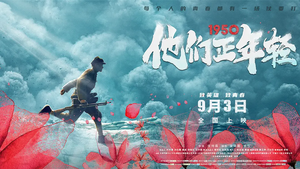

《龙虎武师》，魏海军
北京集智映像影视文化有限公司
风靡世界的香港动作电影，背后是几代武行的拼搏努力。本片通过访问拍摄近百位武行前辈以及入行新人，勾勒出香港动作电影人几十年来立足本土、冲出亚洲、传承内地的拼搏传奇。



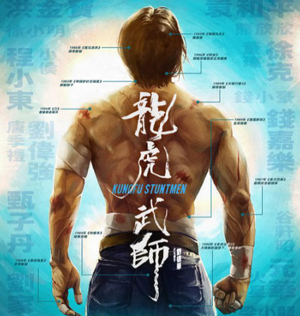

《一个村庄的文学》，贾樟柯
山西西河星汇文化传播有限公司
影片从数十位作家参与、于乡村举办的吕梁文学季开始，追忆马烽，讲述贾平凹、莫言、余华等作家所经历的时代，个人经验、文学表达、新中国记忆彼此交织，展开一个作家与一座村庄、一群作家与70年中国往事的讲述。



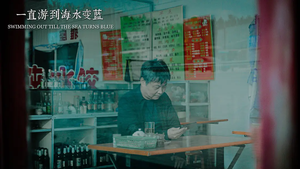

《好好拍电影》，文念中
许鞍华生于辽宁，长于澳门，受教于香港，在中西文化的夹缝中成长与求索。取得香港大学英文及比较文学专业硕士学位后，她远赴伦敦进修。在那里，她找到了电影，从此再没停下脚步。此后，许鞍华师承胡金铨，处女作开辟香港电影新浪潮；于商业与艺术、 类型与文艺之间游走，不断探索自己和这座城市的漂泊状态；六夺金像 三斩金马，仍要为投资犯难发愁；从早年获奖无数到跌入谷底，从不放弃忠于创作的机会。许鞍华对电影和香港始终一片赤诚， 电影伴她活出了人生的圆满



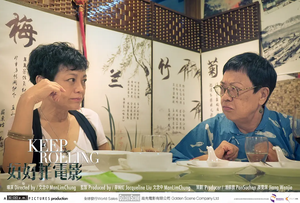

In [ ]:
from IPython.display import Image as Img
from PIL import Image as pil

P1A = ''
P1A += '一些国产纪录片在公示发布间隔期间获得了公映许可，暂未反应在公示内，'
P1A += '另有一些影片适用引进流程，因此也不在公示范围内。'
P1A += '近期上映的纪录电影有《{}》，'.format('》、《'.join(df_onscreen['片名']))
P1A += '主题覆盖了{}。'.format('、'.join(df_onscreen['主题'].unique()))

print(P1A)

path_posters = '/content/drive/MyDrive/Github/Content/tools/articles/img/posters'

for i, row in df_onscreen.iterrows():
  txt = '《{}》，'.format(row['片名'])
  txt += '{}\n'.format(row['编剧'])
  if not pd.isna(row['备案单位']):
    txt +=  '{}\n'.format(row['备案单位'])
  txt += '{}\n'.format(row['梗概'])
  print(txt)
  image = pil.open(path_posters + '/' + row['img_poster'])
  image.thumbnail([300, sys.maxsize], pil.ANTIALIAS)
  image.save(path_posters + '/' + row['img_poster'], format='png')
  display(Img(path_posters + '/' + row['img_poster'], width=300))

##[8.4] P2 公示的58部纪录电影的平均项目周期预计超过744天。其中，从备案到获得公映许可最快的是中国电影股份有限公司的《我们和《金刚川》》，历时83日，耗时最久的是陕西培植影视文化传播有限公司的《书匠》，历时1566日。共有23部影片改过名，9部影片变更过第一出品单位。

In [ ]:
P2 = ''

P2 += '公示的{}部纪录电影的平均项目周期预计超过{}天。'.format(df.shape[0], 
                                    df['备案至获得公映许可'].mean().days
                                    )

nearest = df['备案至获得公映许可'].sort_values().min()
P2 += '其中，从备案到获得公映许可最快的是{}的'.format(
    '、'.join(df.loc[df['备案至获得公映许可'] == nearest, '第一出品单位'].to_numpy())
)
P2 += '《{}》，'.format(
    '、'.join(df.loc[df['备案至获得公映许可'] == nearest, '片名'].to_numpy())
    )
P2 += '历时{}日，'.format(
    df.loc[df['备案至获得公映许可'] == nearest, '备案至获得公映许可'].iloc[0].days
)

df['公示日期'] = df['公示日期'].astype('datetime64')
farthest = df['备案至获得公映许可'].sort_values().max()
P2 += '耗时最久的是{}的'.format(
    '、'.join(df.loc[df['备案至获得公映许可'] == farthest, '第一出品单位'].to_numpy())
)
P2 += '《{}》，'.format(
    '、'.join(df.loc[df['备案至获得公映许可'] == farthest, '片名'].to_numpy())
    )
P2 += '历时{}日。'.format(
    df.loc[df['备案至获得公映许可'] == farthest, '备案至获得公映许可'].iloc[0].days
)

P2 += '本次数据集中共有{}部影片改过名，'.format(df_view[df_view['备案名'] != ''].shape[0])
P2 += '{}部影片变更过第一出品单位。'.format(
    df_view[df_view['原备案单位'] != ''].shape[0])

print(P2)

公示的58部纪录电影的平均项目周期预计超过744天。其中，从备案到获得公映许可最快的是中国电影股份有限公司的《我们和《金刚川》》，历时83日，耗时最久的是陕西培植影视文化传播有限公司的《书匠》，历时1566日。本次数据集中共有23部影片改过名，9部影片变更过第一出品单位。


## [8.5] P3 根据现有数据，纪录电影最多产的是国家大剧院4部、中国农业电影电视中心3部、中国电影股份有限公司2部、山西广电音像出版有限责任公司2部和山东新农村数字电影院线有限公司2部。项目周期最短的出品方是中国电影股份有限公司，平均周期127天、中国人民解放军八一电影制片厂，平均周期279天、中央广播电视总台，平均周期279天、深圳市天宇星影视文化有限公司，平均周期336天和北京优视瑞景文化传媒有限公司，平均周期340天。

In [ ]:
df_view.columns

Index(['片名', '备案名', '梗概', '备案至获得公映许可', '是否修改', '第一出品单位', '原备案单位', '编剧', '主题',
       'genre', 'time', 'kw'],
      dtype='object')

In [ ]:
df['备案至获得公映许可天数'] = df['备案至获得公映许可'].apply(lambda x: x.days)
df_speed = df.groupby('第一出品单位')['备案至获得公映许可天数'].mean().rename('天数').reset_index()
tmp_count = df.groupby('第一出品单位')['片名'].count().rename('部数').reset_index()
df_speed['部数'] = tmp_count['部数'].copy()
tmp_regcount = df_reg[df_reg['电影类别'] == '纪录片'].groupby(
    '备案单位')['片名'].count().rename('备案数量').reset_index()
tmp_regcount.columns = ['第一出品单位', '备案数量']
df_speed = df_speed.sort_values('天数')
df_speed = df_speed.merge(tmp_regcount, on='第一出品单位', how='left')

P3 = ''

df_speed_sorted = df_speed.sort_values('部数', ascending=False)
T, cnt = 5, 0
for i, row in df_speed_sorted.iterrows():
  if cnt == 0:
    P3 += '根据现有数据，纪录电影最多产的是'
  if row['部数'] > 1:
    if cnt == T-2:
      P3 += row['第一出品单位']
      P3 += '{}部和'.format(row['部数'])     
    elif cnt < T:
      P3 += row['第一出品单位']
      P3 += '{}部、'.format(row['部数'])
    i += 1
    cnt += 1
  else:
    break
P3 = P3.rstrip('、') + '。'

df_speed_sorted = df_speed.sort_values('天数')
T, cnt = 5, 0
for i, row in df_speed_sorted.iterrows():
  if cnt == 0:
    P3 += '项目周期最短的出品方是'
  if row['天数'] > 0:
    if cnt == T-2:
      P3 += row['第一出品单位']
      P3 += '，平均周期{}天和'.format(int(row['天数'])) 
    elif cnt < T:
      P3 += row['第一出品单位']
      P3 += '，平均周期{}天、'.format(int(row['天数']))
    i += 1
    cnt += 1
  else:
    break
P3 = P3.rstrip('、') + '。'
print(P3)

根据现有数据，纪录电影最多产的是国家大剧院4部、中国农业电影电视中心3部、中国电影股份有限公司2部、山西广电音像出版有限责任公司2部和山东新农村数字电影院线有限公司2部。项目周期最短的出品方是中国电影股份有限公司，平均周期127天、中国人民解放军八一电影制片厂，平均周期279天、中央广播电视总台，平均周期279天、深圳市天宇星影视文化有限公司，平均周期336天和北京优视瑞景文化传媒有限公司，平均周期340天。


## [8.6] P4 本批次中，大数据分析识别出7部上市影视公司关联项目，占比12.28%。结合主题与出品方实力，慷田AI识别资金实力较为充足的项目有《我爱你，中国》、《城市梦》、《棒！少年》、《保家卫国——抗美援朝光影纪实》、《我们和《金刚川》》、《爱我长城》、《日暮·归乡》，题材类型包括了人物聚焦、人文体育、战争与革命、制作记录。

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df.loc[df['第一出品单位'].fillna('').str.contains(pat_public, regex=True)]
df_focus = df_focus[df_focus['片名'] != '顺子加油']
df_focus

In [ ]:
idx_remove = []
df_focus_narrowed = df_focus[~df_focus.index.isin(idx_remove)]

In [ ]:
P4 = ''
P4 += '本批分析的影片中，慷田AI识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
P4 += '占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
P4 += '结合主题与出品方实力，慷田AI识别资金实力较为充足的项目有《{}》，'.format(
    '》、《'.join(df_focus_narrowed['片名']))
P4 += '题材类型包括了{}。'.format(
    '、'.join(df_focus_narrowed.主题.unique()))

print(P4)

本批分析的影片中，慷田AI识别出7部上市影视公司关联项目，占比12.28%。结合主题与出品方实力，慷田AI识别资金实力较为充足的项目有《我爱你，中国》、《城市梦》、《棒！少年》、《保家卫国——抗美援朝光影纪实》、《我们和《金刚川》》、《爱我长城》、《日暮·归乡》，题材类型包括了人物聚焦、人文体育、战争与革命、制作记录。


##[8.7] P5 按题材展示词云图

In [ ]:
%%capture
df['src_img'] = None
df['tgt_img'] = None

In [ ]:
df_view.columns

NameError: ignored

In [ ]:
for i in df.index:
  ls = [df.loc[i, '片名']] * 10
  ls += [df.loc[i, '预测片名']] *6
  ls += df.loc[i, '主要角色']*3
  ls += [df.loc[i, '主题']] *3
  ls += [df.loc[i, '年代']]*2
  ls += df.loc[i, 'kw']
  ls += [df.loc[i, '第一出品单位']]
  img_fn = df.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_topics2img.loc[
        df_topics2img['主题'] == df.loc[i, '主题'],
        'img'
    ].iloc[0]
    print(df.loc[i, '主题'])
  fp_generated_img = generate_word_image(ls, img_fn)
  display(fp_generated_img)
  df.loc[i, 'tgt_img'] = fp_generated_img

In [ ]:
P5 = ''

## [8.8] E1 指向电影官网

In [ ]:
#####
E1 = '\n\n'
E1 += ''
E1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += ' http://www.chinafilm.gov.cn/chinafilm 。\n'

print(E1)



慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。



## [8.9] E2\E3, Pointer Text

In [ ]:
E2 = '点击阅读原文查看本期慷田AI影片信详表。'
E3 = '点击阅读原文查看本期慷田AI影片概览分析。'

## [8.10] S0 生成摘要, 自国家电影局启用公映许可公示至今，共计公示纪录电影58部，平均孕期超2.0年，最近一次公示日期为2021年1月25日。改名的有23部，变更第一出品方的有9部，主题集中在人物聚焦、戏曲、人文游记、人文风光和历史变迁。令近期公映中的纪录电影有《1950他们正年轻》、《龙虎武师》、《一个村庄的文学》、《好好拍电影》。

In [ ]:
df_view.columns

Index(['片名', '备案名', '梗概', '备案至获得公映许可', '是否修改', '第一出品单位', '原备案单位', '编剧', '主题',
       'genre', 'time', 'kw', 'tgt_img'],
      dtype='object')

In [ ]:
df['备案至获得公映许可'].mean()

Timedelta('744 days 20:16:33.103448272')

In [ ]:
S0 = '自国家电影局启用公映许可公示至今，'
S0 += '共计公示纪录电影{}部，'.format(df.shape[0])
S0 += '平均孕期超{}年，'.format(round(df['备案至获得公映许可'].mean().days/365, 1))
S0 += '最近一次公示日期为{}。'.format(issue_name)
S0 += '改名的有{}部，'.format(df_view.loc[df_view['备案名'] != '',:].shape[0])
S0 += '变更第一出品方的有{}部，'.format(df_view.loc[df_view['原备案单位'] != '',:].shape[0])

df_topics = df.groupby('主题')['片名'].count().rename('数量').reset_index()
df_topics_sorted = df_topics.sort_values('数量', ascending=False)

S0 += '主题集中在{}'.format('、'.join(df_topics_sorted['主题'][:4]))
S0 += '和{}。'.format(df_topics_sorted['主题'][4:5].iloc[0])
S0 += '令近期公映中的纪录电影有《{}》。'.format('》、《'.join(df_onscreen['片名']))
#focus = ['《'+ name + '》' for name in df_focus_narrowed['片名'].to_numpy()]
#S0 += '{}'.format('、'.join(focus))
#S0 += '…'

print(S0)

自国家电影局启用公映许可公示至今，共计公示纪录电影58部，平均孕期超2.0年，最近一次公示日期为2021年1月25日。改名的有23部，变更第一出品方的有9部，主题集中在人物聚焦、戏曲、人文游记、人文风光和历史变迁。令近期公映中的纪录电影有《1950他们正年轻》、《龙虎武师》、《一个村庄的文学》、《好好拍电影》。


## [8.11] Save and Load df

In [ ]:
# Save records for current release issue
df.to_pickle(path_records + '/df_releases_documentary_{}.pkl'.format(
    str_date_curr_release))

df_onscreen.to_pickle(
    path_records + '/df_releases_documentary_onscreen_{}.pkl'.format(
        str_date_curr_release))

In [ ]:
df = pd.read_pickle(
    path_records + '/df_releases_documentary_{}.pkl'.format(
        str_date_curr_release))

df_onscreen = pd.read_pickle(
    path_records + '/df_releases_documentary_onscreen_{}.pkl'.format(
        str_date_curr_release))

# [9] Output Word Doc

## [9.1] Install Docx Lib

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

from docx.shared import Pt
from PIL import Image as pil

## [9.2] Write Overview to docx and download

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'ChinaFilm_Documentary_Releases_Overview_' \
  + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)

doc.add_paragraph(P1A)
path_posters = '/content/drive/MyDrive/Github/Content/tools/articles/img/posters'
for i, row in df_view.iterrows():
  txt = '《{}》，'.format(row['片名'])
  txt += '{}\n'.format(row['编剧'])
  if not pd.isna(row['备案单位']):
    txt +=  '{}\n'.format(row['备案单位'])
  txt += '{}\n'.format(row['梗概'])
  fp_img = path_posters + '/' + row['img_poster']
  doc.add_picture(fp_img, width =Inches(4))
  doc.add_paragraph(txt)

doc.add_paragraph('\n' + P2)

doc.add_paragraph(P3)

doc.add_paragraph(P4)

df_view['tgt_img'] = df['tgt_img'].copy()
ls_topic_sorted = df.groupby('主题')['片名'].count().sort_values(
    ascending=False).reset_index()
ls_topic_sorted = ls_topic_sorted['主题'].tolist()
for topic in ls_topic_sorted:
  dftmp = df_view[df_view['主题'].str.contains(topic)]
  doc.add_heading(topic, 1)
  for i, row in dftmp.iterrows():
    txt = '《{}》，{}，'.format(row['片名'], row['编剧'])
    txt += '项目周期  {}\n'.format(row['备案至获得公映许可'])
    if row['备案名'] != '':
      txt += ' (曾用名《{}》)\n'.format(row['备案名'])
    txt += '{}\n'.format(row['第一出品单位'])
    if row['原备案单位'] != '': 
      txt += '原备案单位：{}\n'.format(row['原备案单位'])
    doc.add_paragraph(txt)

    doc.add_picture(row['tgt_img'], width =Inches(4))

doc.add_paragraph(E1)
doc.add_paragraph(E2)

doc.save(path_doc + '/ChinaFilm_Documentary_Releases_Overview_' + str_date_curr_release +'.docx')

In [ ]:
# Download Document
from google.colab import files

files.download(path_doc + '/ChinaFilm_Documentary_Releases_Overview_' + str_date_curr_release +'.docx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [9.3] Write Table to docx and download

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'

doc = Document()
doc.core_properties.title = 'China Film Documentary Registration Table' \
  + issue_name

doc.add_heading('{}纪录片公映表'.format(issue_name), 0)

p = doc.add_paragraph(S0, style='Intense Quote')

df_view.fillna('')
table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  if row['备案名'] != '':
    row_cells[0].text += ' (原备案名《{}》)'.format(row['备案名'])

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧'] 
  
  row_cells = table.add_row().cells
  row_cells[0].text = '备案至获取公映许可' + row['备案至获得公映许可']
  if row['是否修改'] == '是':
    row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  if not pd.isna(row['第一出品单位']):
    row_cells[0].text = '第一出品单位: ' + row['第一出品单位']
  if row['原备案单位'] != '': 
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案单位：{}'.format(row['原备案单位'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(E1)
doc.add_paragraph(E3)

doc.save(path_doc + '/ChinaFilm_Documentary_Releases_Table_' + issue_name + '.docx')

In [ ]:
files.download(path_doc + 
               '/ChinaFilm_DocumentaryRelease_Table_' + issue_name + '.docx')

FileNotFoundError: ignored